In [57]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Mexico','data')

In [3]:
STATES = gpd.read_file(os.path.join('..','..','geometry','MX_states.geojson'))

In [4]:
INFO = pd.read_csv(os.path.join(dir_base,'INFO.csv'))

In [5]:
nn = 0

states_count = []
for nn in range(len(STATES)):
    len_stations = len(INFO[INFO['Estado']==STATES['name'].str.upper()[nn]])
    states_count.append((STATES['name'][nn],len_stations))
states_dict = dict(states_count)
stations_df = pd.DataFrame(list(states_dict.items()), columns=['name', 'NumEstaciones'])

In [6]:
STATES = STATES.merge(stations_df, on='name', how='left')

Export figure to: ../../images/Staion_count.png


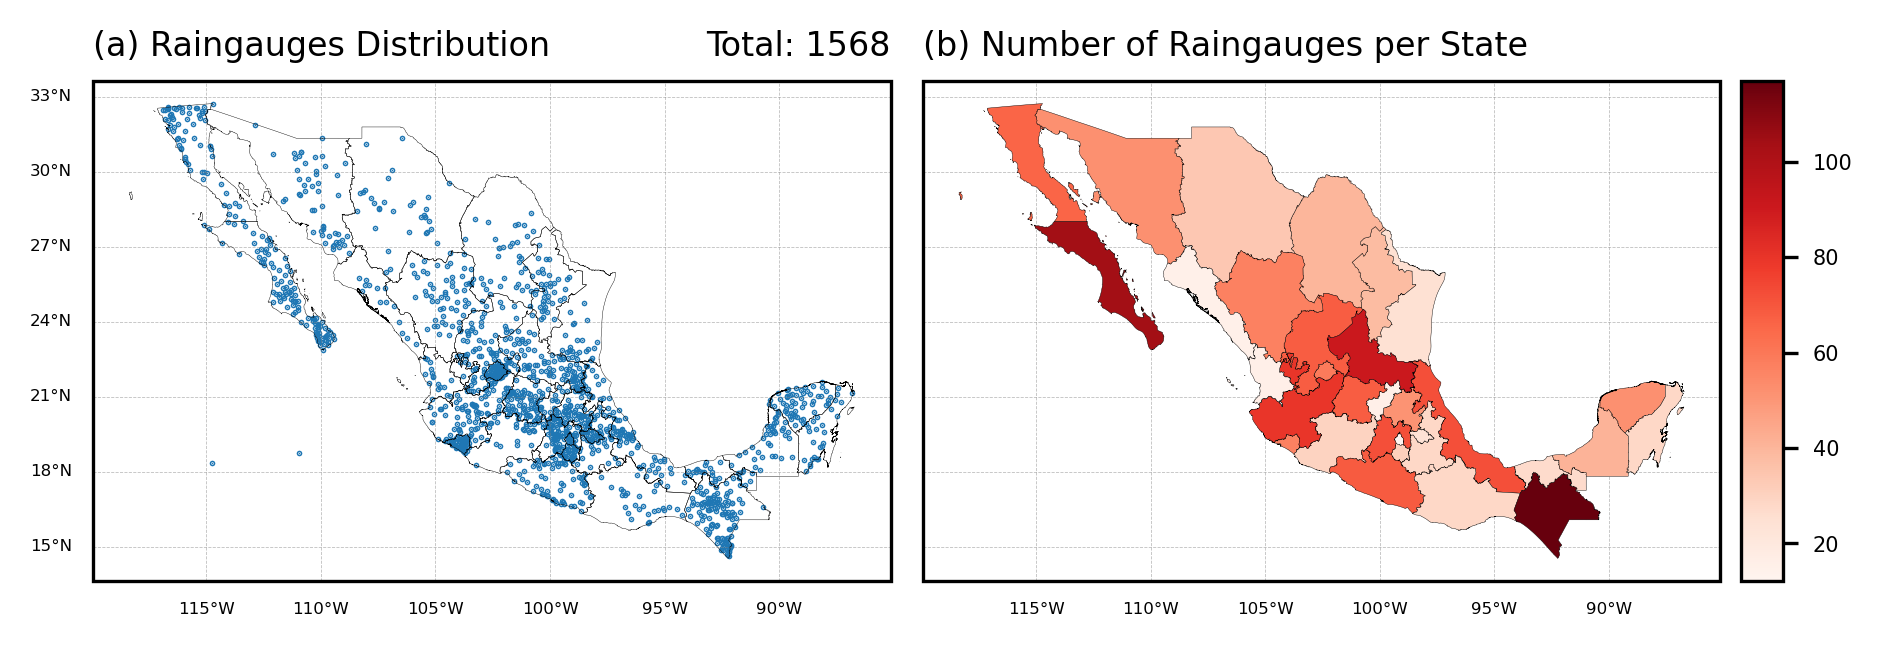

In [39]:
cmap = plt.cm.Reds
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7,5), dpi=300)
gs = gridspec.GridSpec(1, 2)

# =====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
STATES.plot(facecolor='None', ax=ax1, linewidth=0.1, zorder=10)
ax1.scatter(INFO['Longitud'],INFO['Latitud'],s=0.5,marker='.')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(a) Raingauges Distribution', fontsize=8, loc='left')
ax1.set_title(f'Total: {len(INFO)}', fontsize=8, loc='right')

# =====================================================================================================
ax1 = plt.subplot(gs[0, 1], projection=proj)
STATES.plot(column='NumEstaciones', cmap=cmap, linewidth=0.1, edgecolor='black', ax=ax1, zorder=10)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# Opcional: agregar colorbar
sm = plt.cm.ScalarMappable(
                cmap=cmap, 
                norm=plt.Normalize(vmin=STATES['NumEstaciones'].min(), vmax=STATES['NumEstaciones'].max()))
sm._A = []  # Para que funcione con colorbar
cbar_ax = fig.add_axes([0.91, 0.328, 0.02, 0.3338])#0.91
cbar = fig.colorbar(sm,  cax=cbar_ax, shrink=0.5)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) Number of Raingauges per State', fontsize=8, loc='left')

# =====================================================================================================
plt.subplots_adjust(wspace=0.04, hspace=0.16)

salida = os.path.join('..','..','images',f'Staion_count.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [8]:
estados = np.unique(INFO['Estado'].values)

st_name, st_num = [], []

for est in range(len(estados)):
    print(f'State: {estados[est]}')
    INFO_State = INFO[INFO['Estado']==estados[est]]
    INFO_State = INFO_State.reset_index(drop=True)

    Sdata = []
    Edata = []
    for nn in range(len(INFO_State)):
        data_ = pd.read_csv(os.path.join(dir_base,'clear',INFO_State['File'][nn]))
        data_ = data_.dropna(subset=['PRECIP']).reset_index(drop=True)
        data_['FECHA'] = pd.to_datetime(data_['FECHA'])

        Sdata_ = data_['FECHA'][0].strftime('%d-%m-%Y')
        Edata_ = data_['FECHA'][len(data_)-1].strftime('%d-%m-%Y')

        Sdata.append(Sdata_)
        Edata.append(Edata_)

    Sdata = pd.to_datetime(Sdata, dayfirst=True)
    Edata = pd.to_datetime(Edata, dayfirst=True)
    Sdata = pd.to_datetime(Sdata, format='%d-%m-%Y')
    Edata = pd.to_datetime(Edata, format='%d-%m-%Y')

    start_limit = pd.to_datetime('2000-01-01')
    end_limit = pd.to_datetime('2023-12-31')

    filtered_indices = [
        i for i, (start, end) in enumerate(zip(Sdata, Edata))
        if start <= start_limit and end >= end_limit
    ]

    st_name.append((estados[est],len(filtered_indices)))
    # st_num.append()

    fig = plt.figure(figsize=(5,2), dpi=300)
    gs = gridspec.GridSpec(1, 1)

    # =====================================================================================================
    ax1 = plt.subplot(gs[0, 0])
    for nn in range(len(Sdata)):
        if nn in filtered_indices:
            ax1.hlines(y=nn, xmin=pd.to_datetime(Sdata[nn]), xmax=pd.to_datetime(Edata[nn]), color='steelblue', linewidth=1)
        else:
            ax1.hlines(y=nn, xmin=pd.to_datetime(Sdata[nn]), xmax=pd.to_datetime(Edata[nn]), color='tomato', linewidth=1)

    ax1.axvline(pd.to_datetime('01-01-2000', dayfirst=True), linewidth=0.8, color='k', linestyle='--', label='01/01/2020')
    ax1.axvline(pd.to_datetime('31-12-2023', dayfirst=True), linewidth=0.8, color='k', linestyle='--', label='31/12/2023')
    
    ax1.plot([],[], color='steelblue', linewidth=1,label='Complete')
    ax1.plot([],[], color='tomato', linewidth=1,label='Incomplete')

    ax1.grid(linewidth=0.3, linestyle='--')
    ax1.tick_params(axis='both', which='major', labelsize=5)
    
    plt.legend(fontsize=4)

    ax1.set_xlim(pd.to_datetime('1920-01-01'), pd.to_datetime('2025-12-31'))
    ax1.set_title(f'{estados[est]}',fontsize=6,loc='left')
    ax1.set_title(f'2000 to 2023: {len(filtered_indices)}/{len(Sdata)}',fontsize=6,loc='center')
    ax1.set_title(f'Timeline',fontsize=6,loc='right')
    ax1.set_xlabel('Date',fontsize=6)
    ax1.set_ylabel('Stations',fontsize=6)

    # =====================================================================================================
    plt.close()
    
    salida = os.path.join('..','..','images',f'Timeline_{estados[est]}.png')
    print(f'Export figure to: {salida}')
    # plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

State: AGUASCALIENTES
Export figure to: ../../images/Timeline_AGUASCALIENTES.png
State: BAJA CALIFORNIA
Export figure to: ../../images/Timeline_BAJA CALIFORNIA.png
State: BAJA CALIFORNIA SUR
Export figure to: ../../images/Timeline_BAJA CALIFORNIA SUR.png
State: CAMPECHE
Export figure to: ../../images/Timeline_CAMPECHE.png
State: CHIAPAS
Export figure to: ../../images/Timeline_CHIAPAS.png
State: CHIHUAHUA
Export figure to: ../../images/Timeline_CHIHUAHUA.png
State: CIUDAD DE MÉXICO
Export figure to: ../../images/Timeline_CIUDAD DE MÉXICO.png
State: COAHUILA DE ZARAGOZA
Export figure to: ../../images/Timeline_COAHUILA DE ZARAGOZA.png
State: COLIMA
Export figure to: ../../images/Timeline_COLIMA.png
State: DURANGO
Export figure to: ../../images/Timeline_DURANGO.png
State: GUANAJUATO
Export figure to: ../../images/Timeline_GUANAJUATO.png
State: GUERRERO
Export figure to: ../../images/Timeline_GUERRERO.png
State: HIDALGO
Export figure to: ../../images/Timeline_HIDALGO.png
State: JALISCO
Expo

In [9]:
St_dict = pd.DataFrame(list(dict(st_name).items()), columns=['name', '2000_2023'])

In [10]:
STATES['name'] = STATES['name'].str.upper()
STATES = STATES.merge(St_dict, on='name', how='left')

In [18]:
STATES['2000_2023'].min(), STATES['2000_2023'].max()

(np.int64(4), np.int64(99))

Export figure to: ../../images/Staion_count_2000_2023.png


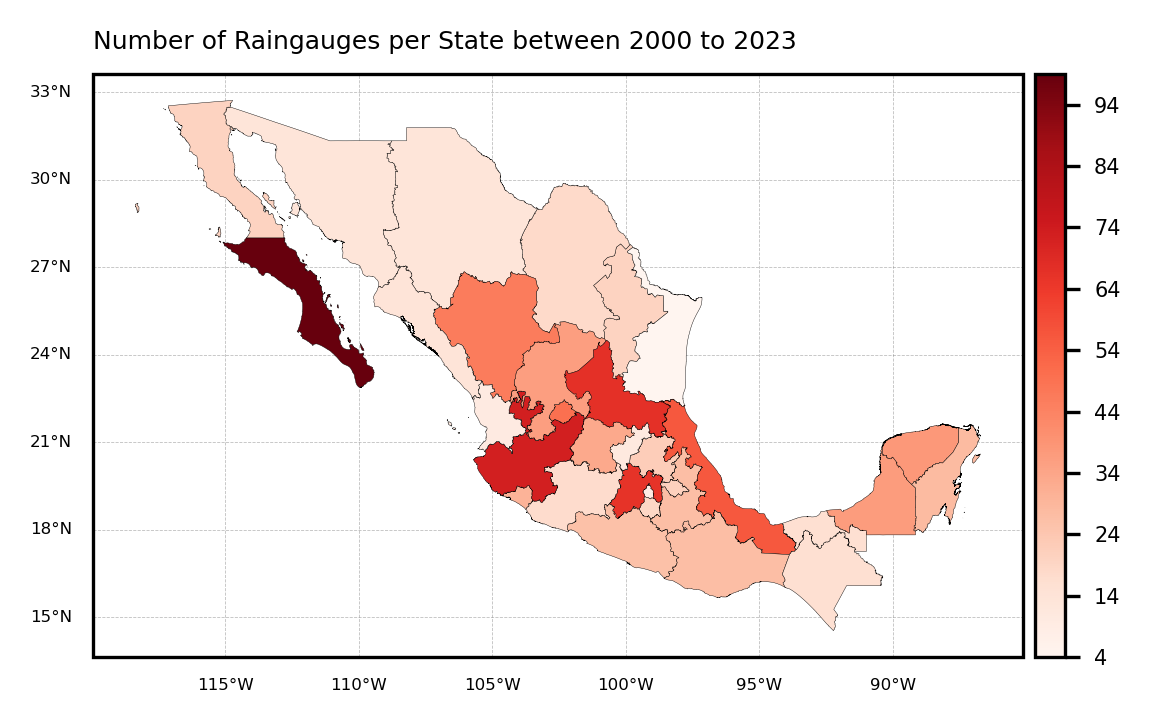

In [40]:
ticks = np.arange(4,114,10)

cmap = plt.cm.Reds
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4), dpi=300)
gs = gridspec.GridSpec(1, 1)

# =====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
STATES.plot(column='2000_2023', cmap=cmap, linewidth=0.1, edgecolor='black', ax=ax1, zorder=10)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

sm = plt.cm.ScalarMappable(
                cmap=cmap, 
                norm=plt.Normalize(vmin=STATES['2000_2023'].min(), vmax=STATES['2000_2023'].max()))
sm._A = []
cbar_ax = fig.add_axes([0.91, 0.252, 0.025, 0.486])#0.91
cbar = fig.colorbar(sm, ticks=ticks, cax=cbar_ax, shrink=0.5)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('Number of Raingauges per State between 2000 to 2023', fontsize=6, loc='left')

salida = os.path.join('..','..','images',f'Staion_count_2000_2023.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

Export figure to: ../../images/States.png


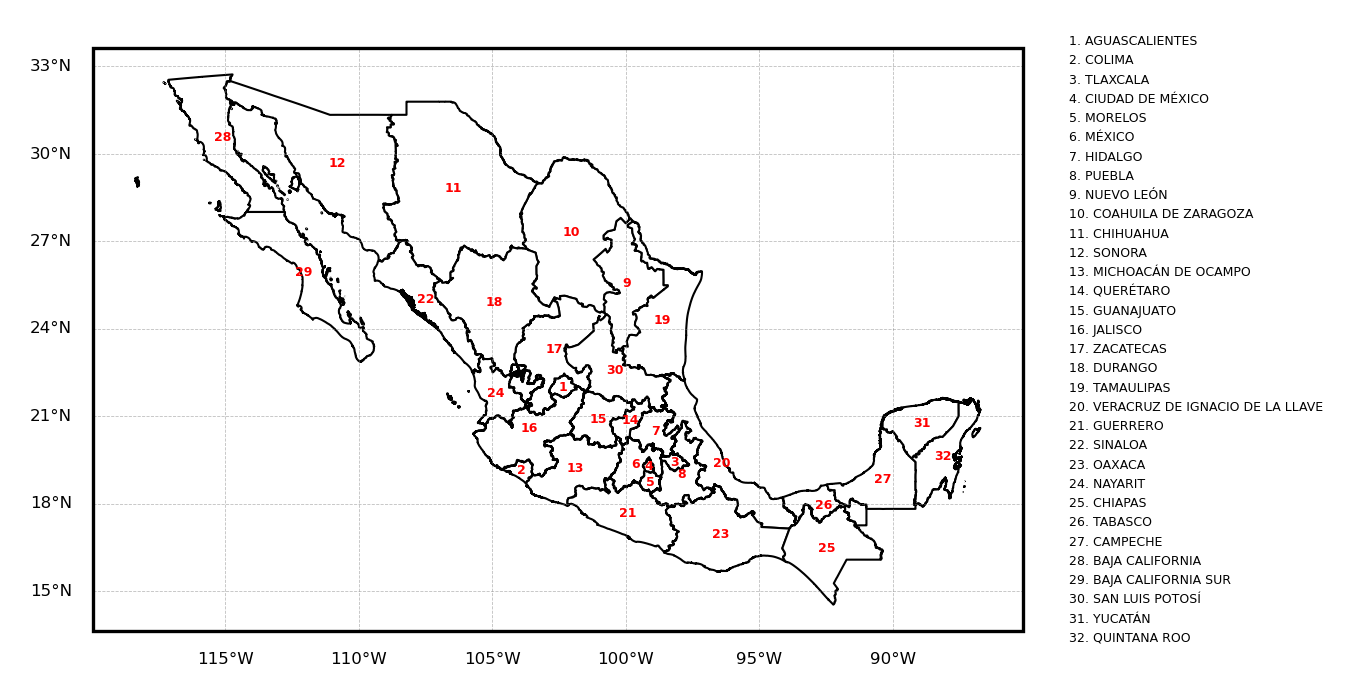

In [77]:
fig = plt.figure(figsize=(4,4), dpi=300)
gs = gridspec.GridSpec(1, 1)

# =====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
STATES.plot(ax=ax1, edgecolor='black', facecolor='white', linewidth=0.5)

# Obtener centroides
centroids = STATES.geometry.centroid

# Agregar número a cada estado en su centroide
for idx, (geom, name) in STATES[['geometry', 'name']].iterrows():
    x, y = geom.centroid.x, geom.centroid.y
    ax1.text(x, y, str(idx+1), ha='center', va='center', fontsize=3, fontweight='bold', color='r')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# Crear lista de "patches" para la leyenda
legend_patches = [mpatches.Patch(color='white', label=f"{idx+1}. {name}") for idx, name in enumerate(STATES['name'])]

# Añadir leyenda
ax1.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5),
        fontsize=3, ncol=1, frameon=False)

salida = os.path.join('..','..','images',f'States.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)